In [1]:
import pandas as pd

In [2]:
df_training = pd.read_csv('training_reviews.csv', names = ['Text', 'Label'], header = None)
df_testing = pd.read_csv('testing_set.csv', names = ['Text', 'Label'], header = None)

In [3]:
import re
import nltk

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text


def clean_up_text(text, flag = 0):
    text = text.lower()
    text = text.replace("\n", " ")
    text = ''.join(c for c in text if c.isalpha() | (c == ' '))
    text_1 = preprocessor(text)
    text_2 = remove_special_characters(text_1)
    
#     if flag == 1:
#         text_2 = simple_stemmer(text_2)
        
    return text_2

# rev = df1.iloc[0]['Text']
# print(clean_up_text(rev)) ## call with no stemming
# print()
# print(clean_up_text(rev, 1)) ## call like this when stemming


#set flag = 1, if you want to stem
def process_data(data, flag = 0):

    for i in range(len(data)):
        if i%1000 == 0:
            print(i)
        data['Text'][i] = clean_up_text(data['Text'][i], flag)
        
    return data



df_training = process_data(df_training)
df_testing = process_data(df_testing)
#df_training_stemmed = process_data(df_training, flag = 1)
#df_testing_stemmed = process_data(df_testing, flag = 1)

0


/home/bagheera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [56]:
from nrclex import NRCLex
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Feature Set, is ordered by Length of review, followed by raw_emotio
#Foallaowed by affect_frequencies


def generate_features_via_lexicon(df):
    
    X_2 = []
    Y_2 = []
    
    for i in range(len(df)):
        if i% 1000 == 0:
            print(i)

        review = df['Text'][i]

        text_object = NRCLex(review)
        review = review.split(" ")

        feature_list = []
        feature_list.append(len(review))

        raw_emotions = ["anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"]
        affect_freq = raw_emotions = ["anger", "anticip", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"]


        raw_emotion = text_object.raw_emotion_scores
        for raw_em in raw_emotions:
            if raw_em not in raw_emotion:
                raw_emotion[raw_em] = 0
        raw_emotion = [(k,v) for k,v in raw_emotion.items()]
        raw_emotion.sort()
        #if(i < 10):
            #print(raw_emotion)
        raw_emotion = [v for (k,v) in raw_emotion]
        feature_list.extend(raw_emotion)

        affect_frequencies = text_object.affect_frequencies
        for af in affect_freq:
            if af not in affect_frequencies:
                affect_frequencies[af] = 0
        affect_frequencies = [(k,v) for k,v in affect_frequencies.items()]
        affect_frequencies.sort()
        affect_frequencies = [v for (k,v) in affect_frequencies]
        feature_list.extend(affect_frequencies)

        X_2.append(feature_list)
        Y_2.append(df['Label'][i])
        
    feature_len = len(X_2[0])
    label_list = ["Feature_" + str(i) for i in range(1, feature_len + 1)]

    X_2 = DataFrame(X_2, columns = label_list)
    Y_2 = DataFrame(Y_2, columns = ["Label"])

    return X_2, Y_2

def generate_features_via_Vectorizer(df1, df2):
    X_2 = []
    Y_2 = []
    
    vectorizer = TfidfVectorizer(binary = "true")
    
    for i in range(len(df1)):
        if i% 1000 == 0:
            print(i)

        review = df1['Text'][i]
        X_2.append(review)
        Y_2.append(df1['Label'][i])
        
    for i in range(len(df2)):
        if i% 1000 == 0:
            print(i)

        review = df2['Text'][i]
        X_2.append(review)
        Y_2.append(df2['Label'][i])
        
    X_2 = vectorizer.fit_transform(X_2)
    
    
    
    #X_2 = X_2.toarray()
    
    #print(X_2[0][0])
    
    #print(X_2[0])
    feature_len = len(list(X_2[0]))
    label_list = ["Feature_" + str(i) for i in range(1, feature_len + 1)]

    #X_2 = DataFrame(X_2, columns = label_list)
    Y_2 = DataFrame(Y_2, columns = ["Label"])
    
    
#     print(X_2[0:10])
#     print(Y_2[0:10])
    
    return X_2[0:len(df1)], Y_2[0:len(df1)], X_2[len(df1):], Y_2[len(df1):]    



X1, Y1, X1_Test, Y1_Test = generate_features_via_Vectorizer(df_training, df_testing)
#print(X1[0:10])
#X2, Y2 = generate_features_via_Vectorizer(df_training_stemmed)


X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, test_size = 0.2, random_state = 0)
#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2,Y2, test_size = 0.2, random_state = 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


In [5]:
#X1_Test, Y1_Test = generate_features_via_Vectorizer(df_testing)
#X2_Test, Y2_Test = generate_features_via_lexicon(df_testing_stemmed)

In [14]:
# print(X1_train['Feature_1'])

##Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X1_train, Y1_train)
print("score on validation: " + str(lr.score(X1_test, Y1_test)))
print("score on test: "+ str(lr.score(X1_Test, Y1_Test)))
print("score on training: " + str(lr.score(X1_train, Y1_train)))
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X2_train, Y2_train)
# print("score on validation: " + str(lr.score(X2_test, Y2_test)))
# print("score on test: "+ str(lr.score(X2_Test, Y2_Test)))


/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


score on validation: 0.884
score on test: 0.88468
score on training: 0.9418


In [32]:
Y_LR_v = lr.predict(X1_test)
for i in range(len(Y_LR_v)):
    Y_LR_v[i] = Y_LR_v[i]-1
    
Y_LR_t = lr.predict(X1_Test)
for i in range(len(Y_LR_t)):
    Y_LR_t[i] = Y_LR_t[i]-1
    

In [7]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X1_train, Y1_train)
print("score on validation: "  + str(clf.score(X1_test, Y1_test)))
print("score on Test: " + str(clf.score(X1_Test, Y1_Test)))

# clf = DecisionTreeClassifier()
# clf.fit(X2_train, Y2_train)
# print("score on validation: "  + str(clf.score(X2_test, Y2_test)))
# print("score on Test: " + str(clf.score(X2_Test, Y2_Test)))

score on validation: 0.699
score on Test: 0.69844


score on Train: 1.0


In [8]:
#Bagging Decision Tree

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X1_train, Y1_train)
print("score on validation: " + str(bg.score(X1_test, Y1_test)))
print("score on Test: "+ str(bg.score(X1_Test, Y1_Test)))

# bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
# bg.fit(X2_train, Y2_train)
# print("score on validation: " + str(bg.score(X2_test, Y2_test)))
# print("score on Test: "+ str(bg.score(X2_Test, Y2_Test)))

/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


score on validation: 0.7652
score on Test: 0.76692


In [18]:
#Boosting Decision Tree

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=5),n_estimators=100,learning_rate=0.6)
adb.fit(X1_train, Y1_train)
print("score on validation: " + str(adb.score(X1_test, Y1_test)))
print("score on Test: "+ str(adb.score(X1_Test, Y1_Test)))

# adb.fit(X2_train, Y2_train)
# print("score on validation: " + str(adb.score(X2_test, Y2_test)))
# print("score on Test: "+ str(adb.score(X2_Test, Y2_Test)))

/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


score on validation: 0.7954
score on Test: 0.79036


In [31]:
Y_BDT_v = lr.predict(X1_test)
for i in range(len(Y_BDT_v)):
    Y_BDT_v[i] = Y_BDT_v[i]-1
    
Y_BDT_t = lr.predict(X1_Test)
for i in range(len(Y_BDT_t)):
    Y_BDT_t[i] = Y_BDT_t[i]-1
    
print(Y_BDT_v[0:10])

[1 0 0 0 0 1 1 0 0 0]


In [17]:
print("score on Test: "+ str(adb.score(X1_train, Y1_train)))

score on Test: 0.82705


In [10]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=12)
rf.fit(X1_train, Y1_train)
print("score on Validation: " + str(rf.score(X1_test, Y1_test)))
print("score on Test: "+ str(rf.score(X1_Test, Y1_Test)))

# rf.fit(X2_train, Y2_train)
# print("score on Validation: " + str(rf.score(X2_test, Y2_test)))
# print("score on Test: "+ str(rf.score(X2_Test, Y2_Test)))

/home/bagheera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


score on Validation: 0.7748
score on Test: 0.76024


In [11]:
from sklearn.svm import LinearSVC

svm=LinearSVC(C=0.0001)
svm.fit(X1_train, Y1_train)

print("score on Validation: " + str(svm.score(X1_test, Y1_test)))
print("score on Test: "+ str(svm.score(X1_Test, Y1_Test)))

score on Validation: 0.8316
score on Test: 0.82772


/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [34]:
Y_SVM_v = lr.predict(X1_test)
for i in range(len(Y_SVM_v)):
    Y_SVM_v[i] = Y_SVM_v[i]-1
    
Y_SVM_t = lr.predict(X1_Test)
for i in range(len(Y_SVM_t)):
    Y_SVM_t[i] = Y_SVM_t[i]-1
    
    
print(Y_SVM_v[0:10])

[1 0 0 0 0 1 1 0 0 0]


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

def sampling(Y):
    ret_Y = []
    for y in Y:
        e = np.random.binomial(size =1, n=1, p = y-1)
        ret_Y.append(1 + e)
    return ret_Y

def rounding(Y):
    ret_Y = []
    for y in Y:
        ret_Y.append(y.round())
    return ret_Y

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X1_train, Y1_train)
Y_pred = regressor.predict(X1_test)
Y1_pred = regressor.predict(X1_Test)

print("score on validation (sampling):", accuracy_score(Y1_test, sampling(Y_pred)))
print("score on Test (sampling):", accuracy_score(Y1_Test, sampling(Y1_pred)))
print("score on validation (rounding):", accuracy_score(Y1_test, rounding(Y_pred)))
print("score on Test (rounding):", accuracy_score(Y1_Test, rounding(Y1_pred)))

# regressor.fit(X2_train, Y2_train)
# Y_pred_2 = regressor.predict(X2_test)
# Y2_pred_2 = regressor.predict(X2_Test)

# print("score on validation (sampling):", accuracy_score(Y2_test, sampling(Y_pred_2)))
# print("score on Test (sampling):", accuracy_score(Y2_Test, sampling(Y2_pred_2)))
# print("score on validation (rounding):", accuracy_score(Y2_test, rounding(Y_pred_2)))
# print("score on Test (rounding):", accuracy_score(Y2_Test, rounding(Y2_pred_2)))

/home/bagheera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


KeyboardInterrupt: 

In [46]:
################################# Ensemble Methods #############################
from collections import Counter

##Y_LR_v, Y_BDT_v, Y_SVM_v

Votes_v = []
Votes_t = []

for i in range(len(Y_LR_v)):
    Votes_v.append([Y_LR_v[i], Y_BDT_v[i], Y_SVM_v[i]])
    
for i in range(len(Y_LR_t)):
    Votes_t.append([Y_LR_t[i], Y_BDT_t[i], Y_SVM_t[i]])

### Output majority vote
### Just run Boosting on features, over X1_test, Y1_test
### Run Random Forest over ""
### Same thing but now including with feature set

def majority(l):
    c = Counter(l)
    value, count = c.most_common()[0]
    
    return value


###Classifier that outputs majority###
Y_pred = [majority(i) + 1 for i in Votes_t]

print(accuracy_score(Y1_Test, Y_pred))

0.88468


In [48]:
##########Boosting ##########
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)

bg.fit(Votes_v, Y1_test)
#print("score on validation: " + str(bg.score(X1_train, Y1_train)))
print("score on Test: "+ str(bg.score(Votes_t, Y1_Test)))

score on Test: 0.88468


/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [49]:
######### Random Forest ############
rf = RandomForestClassifier(n_estimators=30, max_depth=12)
rf.fit(Votes_v, Y1_test)
#print("score on Validation: " + str(rf.score(X1_test, Y1_test)))
print("score on Test: "+ str(rf.score(Votes_t, Y1_Test)))

score on Test: 0.88468


/home/bagheera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
from scipy import sparse

print(X1_Test.shape)
print(X1_test.shape)

X1_test = sparse.hstack((X1_test,np.array(Y_LR_v)[:,None]))
X1_test = sparse.hstack((X1_test,np.array(Y_BDT_v)[:,None]))
X1_test = sparse.hstack((X1_test,np.array(Y_SVM_v)[:,None]))

X1_Test = sparse.hstack((X1_Test,np.array(Y_LR_t)[:,None]))
X1_Test = sparse.hstack((X1_Test,np.array(Y_BDT_t)[:,None]))
X1_Test = sparse.hstack((X1_Test,np.array(Y_SVM_t)[:,None]))

print(X1_Test.shape)
print(X1_test.shape)

##########Boosting ##########
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)

bg.fit(X1_test, Y1_test)
#print("score on validation: " + str(bg.score(X1_train, Y1_train)))
print("score on Test: "+ str(bg.score(X1_Test, Y1_Test)))


(25000, 176068)
(5000, 176068)
(25000, 176071)
(5000, 176071)


/home/bagheera/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


score on Test: 0.88228


In [58]:
rf = RandomForestClassifier(n_estimators=30, max_depth=12)
rf.fit(X1_test, Y1_test)
#print("score on Validation: " + str(rf.score(X1_test, Y1_test)))
print("score on Test: "+ str(rf.score(X1_Test, Y1_Test)))

/home/bagheera/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


score on Test: 0.8626


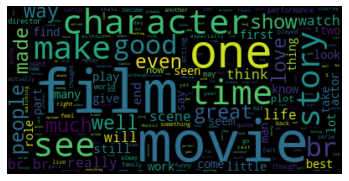

In [60]:
################### word cloud

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt


pos_reviews = df_training[df_training.Label == 1]
neg_reviews = df_training[df_training.Label == 2]

text = ""
for i in range(len(pos_reviews)):
    text += pos_reviews['Text'][i]
    
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


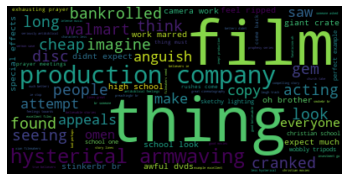

In [76]:
neg_reviews.head()

text2 = ""

# print(neg_reviews.iloc[0][0])
for i in range(len(neg_reviews)):
    text2 += neg_reviews.iloc[0][0]


# for i in range(len(neg_reviews)):
#     print(type(neg_reviews['Text']))
# #     print(neg_reviews['Text'][2])
# #     text2 += neg_reviews['Text'][i]
    
wordcloud = WordCloud().generate(text2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()